# Deep learning

Learning goals:
1. Get familiar with a state-of-the-art module for deep learning
1. Implement and run a multilayer neural network in PyTorch
1. Understand convolution
1. Implement and run a convolutional neural network in PyTorch

In [140]:
import matplotlib.pyplot as plt
from scipy import signal as ss
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

It might occur that the above imports throw an error, saying `torch` is an unknown module. If so, you have not yet installed `pytorch` properly. Do so by opening a terminal and installing it by calling `conda install pytorch torchvision -c pytorch` (i.e., see https://pytorch.org/get-started/locally/).

When working on a state-of-the-art neural network project you will rely on one of the various neural network frameworks that are available, instead of implementing core functionality by yourself. In this exercise you will work on implementing an MLP and a CNN in the PyTorch framework. 

To get familiar with PyTorch, read the tutorial at https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html. It is a good introduction to PyTorch including setting up data, defining a model, and training a model. 

### Exercise 1: MNIST data (1 point)
We will use the MNIST dataset (handwritten digets) for this assignment. The dataset is a very standard and commonly used benchmark dataset. In this assignment, we will only work with a training and validation dataset. Normally, one would also have a testing dataset, but we will ignore this in this assignment.
1. Load the *MNIST* dataset. Use a training and a validation dataset.
1. Define training and validation data iterators and use a specific batchsize.
1. Inspect the training and validation data by printing (1) the amount of samples in each set and (2) the shape of a data sample.
1. Inspect the training and validation data by plotting some samples (as images).

### Solution 1

images shape :  torch.Size([100, 1, 28, 28])
labels shape :  torch.Size([100])


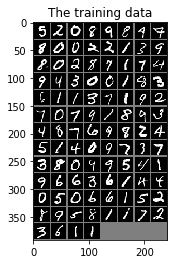

images shape :  torch.Size([100, 1, 28, 28])
labels shape :  torch.Size([100])


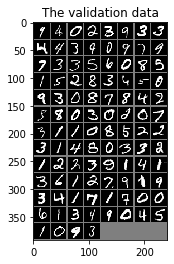

In [160]:
#cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#loading data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data/mnist/train', train=True,
                                        download=True, transform=transform)

validation_size = int(len(trainset)/10)
train_size = len(trainset)-validation_size
train, val = torch.utils.data.random_split(trainset, [train_size, validation_size])

batchsize = 100
trainloader = torch.utils.data.DataLoader(train, batch_size=batchsize, shuffle=True)
validationloader = torch.utils.data.DataLoader(val, batch_size=batchsize, shuffle = True)

def show(image):
    image = image / 2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()
    
iter_train = iter(trainloader)
iter_validation = iter(validationloader)


image, labs = iter_train.next()
print('images shape : ', image.size())
print('labels shape : ', labs.size())

plt.title("The training data")
show(torchvision.utils.make_grid(image))

image2, labs2 = iter_train.next()
print('images shape : ', image2.size())
print('labels shape : ', labs2.size())

plt.title("The validation data")
show(torchvision.utils.make_grid(image2))

### Exercise 2: Training a model (3 points)
Define a function `train_model` with input arguments `model`, `train_data`, `valid_data`, `optimizer`, `criterion`, and `n_epochs`, and output arguments `model`, `train_loss`, `valid_loss`, `train_accuracy`, `valid_accuracy`. We will use this function to train both a MLP as well as a CNN. It therefore has to be generic to any type of model, optimizer, or loss function. The function:
1. Loops over `n_epoch` epochs.
1. Loops over minibatches of both training data `train_data` as well as validation data `valid_data`.
1. Trains the model using the loss function defined by `criterion` and optimizer `optimizer` using the training data.
1. Computes and saves losses for both training and validation data per epoch in `train_loss` and `valid_loss`.
1. Computes and saves accuracies for both training and validation data per epoch in `train_accuracy` and `valid_accuracy`.

### Solution 2

In [164]:
def train_model(model, train_data, valid_data, optimizer, criterion, n_epochs):
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    
    for epoch in range(n_epochs):
        tem_val_loss = 0
        tem_train_loss = 0
        
        correct_train = 0
        total_train = 0
        for i, data in enumerate(train_data):
            inputs, labels = data
            inputs = inputs.reshape(-1,28*28)
            labels = labels
            
            #Forward
            output = model(inputs)
            
            #Loss
            loss = criterion(output, labels)     
            
            #Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tem_train_loss += loss.item()
            
            if i % 180 == 179:    
                #print("{}, {} loss: {}".format(epoch+1, i+1, tem_train_loss/180))
                train_loss.append(tem_train_loss/180)
                tem_train_loss = 0.0
                
            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted==labels).sum().item()
        train_accuracy.append(100*correct_train/total_train)
            
                
        correct_valid = 0
        total_valid = 0        
        for i, data in enumerate(valid_data):
            inputs, labels = data
            inputs = inputs.reshape(-1,28*28)
            labels = labels

            #Forward
            output = model(inputs)
             
            #Loss
            validation_loss = criterion(output, labels)
            tem_val_loss += validation_loss.item()
            if i % 20 == 19:
                #print("{}, {} loss: {}".format(epoch+1, i+1, tem_val_loss/20))
                valid_loss.append(tem_val_loss/20)
                tem_val_loss = 0.0
                    
            _, predicted = torch.max(output.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted==labels).sum().item()
        valid_accuracy.append(100*correct_valid/total_valid)
    
    
    
    return model, train_loss, valid_loss, train_accuracy, valid_accuracy

### Exercise 3: Setup an MLP (1 point)
As a first model, setup a multilayer perceptron:
1. with two linear (i.e., fully connected) weight layers
1. with a hidden layer of 16 ReLU units

### Solution 3

In [165]:
class MLP(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dimension, hidden_dimension)
        self.relu = nn.ReLU()
        self.layer2 = torch.nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

### Exercise 4: Train the MLP (1 point) 
Train the MLP using the MNIST dataset:
1. As optimizer use SGD with a learning rate of 0.001 and momentum of 0.9.
1. As loss function use the cross-entropy loss.
1. Train the MLP in 20 epochs.
1. Plot the training and validation losses as a function of epochs.
1. Plot the training and validation accuracies as a function of epochs.

### Solution 4

In [167]:
mlp = MLP(28*28, 16, 10)#.to(cuda)

optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()
n_epochs = 20

model, train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(mlp, trainloader, validationloader, optimizer, criterion, n_epochs)


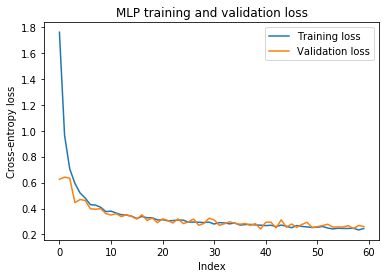

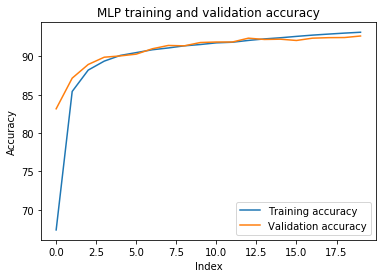

In [170]:
plt.title("MLP training and validation loss")
plt.xlabel("Index")
plt.ylabel("Cross-entropy loss")
plt.plot(train_loss, label = "Training loss")
plt.plot(valid_loss, label = "Validation loss")
plt.legend()
plt.show()

plt.title("MLP training and validation accuracy")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, label = "Training accuracy")
plt.plot(valid_accuracy, label = "Validation accuracy")
plt.legend()
plt.show()

### Exercise 5: Visualize the weights (0.5 points)
The model's weights in a particular layer that the MLP has learned can be found in `model_name.layer_name.weight.data`. Plot the weights of the 16 ReLU units as 2D images.

### Solution 5

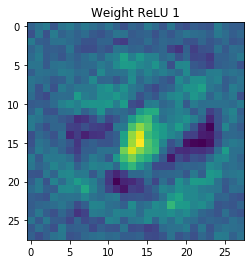

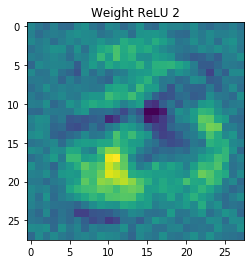

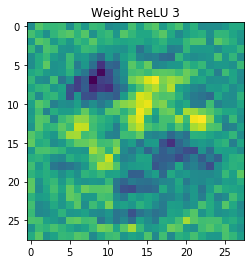

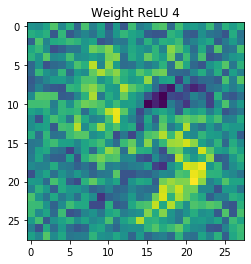

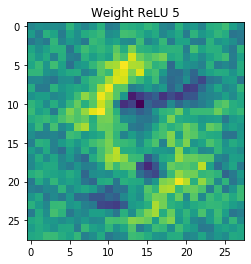

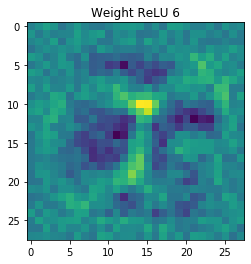

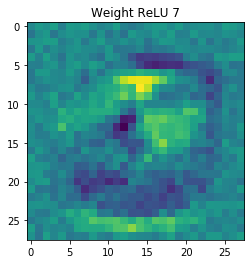

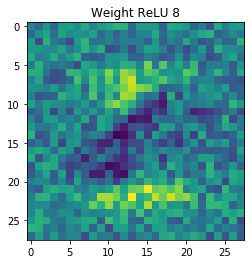

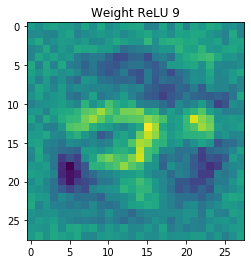

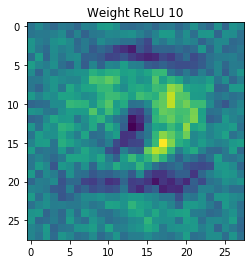

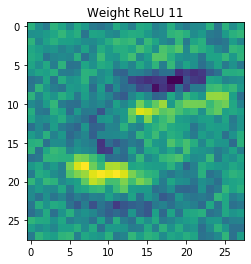

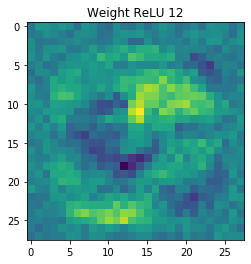

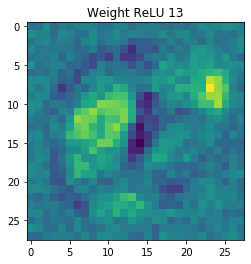

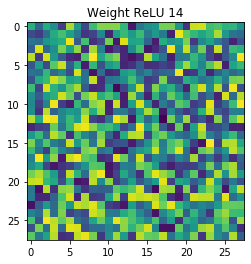

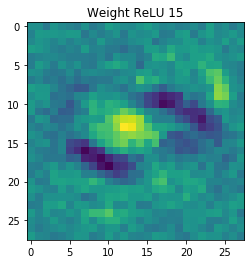

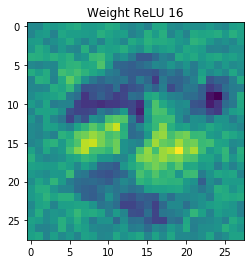

In [171]:
for i in range(16):
    layer = mlp.layer1.weight.data[i]
    npimage = layer.numpy()
    npimage = np.reshape(npimage, (28,28))
    plt.imshow(npimage)
    plt.title("Weight ReLU {}".format(i+1))
    plt.show()

### Exercise 6: Convolution with hand-made kernels (1 point)
In convolutional neural networks we use a mathematical operator between two functions $f$ and $g$ called [*convolution*](https://en.wikipedia.org/wiki/Convolution). In terms of images, one could intuitively think of $f$ as an image, and $g$ as a filter kernel (i.e., a receptive field). For images we need to use 2D convolution: 

$$f(x, y) \ast g(x, y) = \sum^N_{i=-N}\sum^N_{j=-N} f(x, y)g(x-i, y-j)$$

Intuitively, the kernel $g$ is applied on all spatial locations of $f$. You could think of $g$ as having weights that represent how it singles out local input. Usually there are various of these filter kernels $g$, scanning the image for many possible features. 

In this exercise you will perform a simple convolution on one image.
1. Make four $3 \times 3$ kernels. They should represent horizontal, vertical, and the two diagonal line feature detectors.
1. Plot these kernels.
1. Apply the kernels to the image, e.g. by using `convolved2d` from `scipy`.
1. Plot the resulting feature activity map for each of the kernels. 

### Solution 6

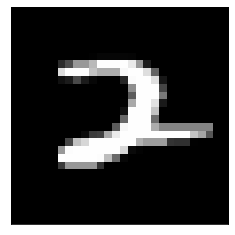

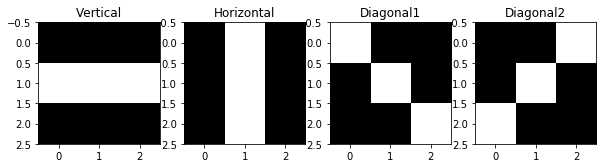

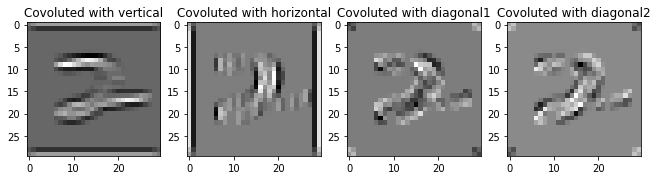

In [172]:
# The image
image = train[2][0].reshape((28, 28))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray")
ax.set_xticks([], []) ; ax.set_yticks([], [])

# 1. Create kernels
horizontal =      [ [-1.0, -1.0, -1.0], 
                    [ 2.0,  2.0,  2.0], 
                    [-1.0, -1.0, -1.0] ]

vertical =        [ [-1.0,  2.0, -1.0], 
                    [-1.0,  2.0, -1.0], 
                    [-1.0,  2.0, -1.0] ]

diagonal1 =       [ [ 2.0, -1.0, -1.0], 
                    [-1.0,  2.0, -1.0], 
                    [-1.0, -1.0,  2.0] ]

diagonal2 =       [ [-1.0, -1.0,  2.0], 
                    [-1.0,  2.0, -1.0], 
                    [ 2.0, -1.0, -1.0] ]


# 2. Plot kernels
fig1, ax1 = plt.subplots(1, 4, figsize=(10, 10))
ax1[0].imshow(horizontal, cmap="gray")
ax1[1].imshow(vertical, cmap="gray")
ax1[2].imshow(diagonal1, cmap="gray")
ax1[3].imshow(diagonal2, cmap="gray")
ax1[0].set_title('Vertical')
ax1[1].set_title('Horizontal')
ax1[2].set_title('Diagonal1')
ax1[3].set_title('Diagonal2')

# 3. Convolve the image with the kernels
from scipy import signal
x1 = signal.convolve2d(horizontal, image)
x2 = signal.convolve2d(vertical, image)
x3 = signal.convolve2d(diagonal1, image)
x4 = signal.convolve2d(diagonal2, image)

# 4. Plot the activity maps
fig2, ax2 = plt.subplots(1, 4, figsize=(11, 11))
ax2[0].imshow(x1, cmap="gray")
ax2[1].imshow(x2, cmap="gray")
ax2[2].imshow(x3, cmap="gray")
ax2[3].imshow(x4, cmap="gray")
ax2[0].set_title('Covoluted with vertical')
ax2[1].set_title('Covoluted with horizontal')
ax2[2].set_title('Covoluted with diagonal1')
ax2[3].set_title('Covoluted with diagonal2')
plt.show()


### Exercise 7: Setup a CNN (1 points)
As a second model, setup a CNN with:
1. One convolutional layer and one linear (i.e., fully connected) weight layer.
1. In the convolutional layer, use $8$ kernels of size $3\times3$ and stride $1$.
1. ReLU units in the hidden layer.
1. Max pooling with kernels of size $2\times2$ and stride $2$.

### Solution 7

In [173]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1)
        self.layer2 = torch.nn.Linear(8*13*13, 10)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = x.view(100,1,28,28)
        out = F.max_pool2d(F.relu(self.layer1(x)), (2, 2), stride=2)
        out = out.view(-1, 8*13*13)
        out = self.layer2(out)
        return out

### Exercise 8: Train the CNN (1 point) 
Train the CNN using the MNIST dataset:
1. As optimizer use SGD with a learning rate of 0.001 and momentum of 0.9.
1. As loss function use the cross-entropy loss.
1. Train the CNN in 20 epochs.
1. Plot the training and validation losses as a function of epochs.
1. Plot the training and validation accuracies as a function of epochs.

### Solution 8

In [174]:
cnn = CNN()
optimizer2 = optim.SGD(cnn.parameters(), lr=0.001, momentum = 0.9)
criterion2 = nn.CrossEntropyLoss()
n_epochs = 20

model2, train_loss2, valid_loss2, train_accuracy2, valid_accuracy2 = train_model(cnn, trainloader, validationloader, optimizer2, criterion2, n_epochs)


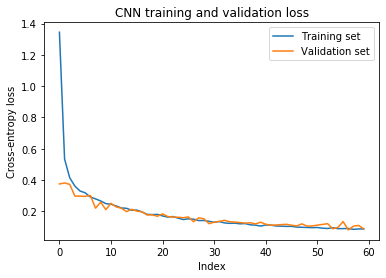

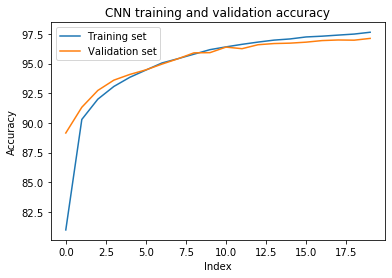

In [177]:
epochs = np.arange(0, 20)
plt.title("CNN training and validation loss")
plt.xlabel("Index")
plt.ylabel("Cross-entropy loss")
plt.plot(train_loss2, label = "Training set")
plt.plot(valid_loss2, label = "Validation set")
plt.legend()
plt.show()

plt.title("CNN training and validation accuracy")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.plot(train_accuracy2, label = "Training set")
plt.plot(valid_accuracy2, label = "Validation set")
plt.legend()
plt.show()

### Exercise 9: Visualize the weights (0.5 points)
The model's weights in the convolutional layer that the CNN has learned can be found in `model_name.layer_name.weight.data`. Plot the kernels as images.

Showing what the first weight layer learns is easy. But this task becomes more difficult in higher layers, and is a current area of research. Here is highly recommended reading on what convolutional neural networks learn: 

[Feature visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

[The building blocks of interpretability](https://distill.pub/2018/building-blocks/)

### Solution 9

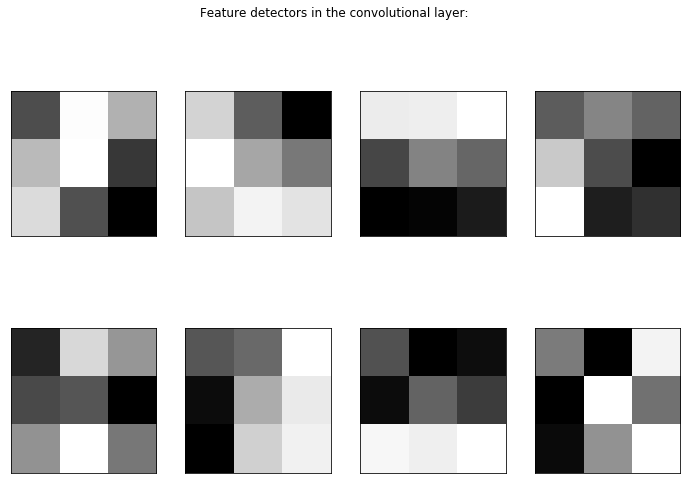

In [163]:
W1 = cnn.layer1.weight.data
fig, axes = plt.subplots(2, 4, figsize=(12,8))
fig.suptitle("Feature detectors in the convolutional layer:")
axes = axes.flatten()
for i, unit in enumerate(W1):
    axes[i].imshow(unit.reshape((3, 3)), cmap="gray")
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])

### Exercise 10: Interpretation (2 points)
1. Which of the two models performed better for classifying MNIST digits in this example? Compare speed of training and test set accuracy. 
1. The main difference of the models is the type of the first layer. Why would a convolutional layer lead to the better succes here? 
1. Explain one argument why the convolution operation is biologically plausible and one argument why it is biologically implausible. 

### Solution 10
1. The CCN performed better in terms of accuracy approximately 92% accuracy for MLP while CCN got approx. 97%. However the CCN took considerably longer to train.
1. Convolutional layers allow you to detect features regardless of their spatial location, resulting in greater conversion mismatch. Other handwriting or small differences make it easier to classify numbers, so it can be interpreted as having higher accuracy.
1. Convolution operation and resulting feature maps could be biologically plausible as it resembles Selfridge's pandemonium model. This is a model that proposes a way how visual information is processed in the human brain based on the detection of elementary features such as line orientation. Convolution operation and resulting feature maps could be biologically implausible as it cannot be integrated well with prior knowledge while the human brain uses prior knowledge extensively.